In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
torch.set_default_dtype(torch.float64)
import torch.nn as nn
import copy
import random

In [2]:
import config as cfg
from model import DeepNN
from utils import relative_l2, set_seed
from train_reg import train_model_reg
from train_pde import train_model_pde

In [3]:
set_seed(0)
model_E = DeepNN().cuda()
model_T = DeepNN().cuda()
[model_E, model_T] = train_model_reg(model_E, model_T, Nfit=300, lr_E=1e-3, lr_T=1e-3)

E: lbfgs : 0 - ref_rl2 9.0303e-01 
T: lbfgs : 0 - ref_rl2 7.4492e-01 
E: lbfgs : 50 - ref_rl2 9.5798e-03 
T: lbfgs : 50 - ref_rl2 5.6126e-03 
E: lbfgs : 100 - ref_rl2 3.0558e-03 
T: lbfgs : 100 - ref_rl2 1.7038e-03 
E: lbfgs : 150 - ref_rl2 2.3532e-03 
T: lbfgs : 150 - ref_rl2 1.0015e-03 
E: lbfgs : 200 - ref_rl2 1.7346e-03 
T: lbfgs : 200 - ref_rl2 9.6260e-04 
E: lbfgs : 250 - ref_rl2 1.7081e-03 
T: lbfgs : 250 - ref_rl2 9.3999e-04 
E: lbfgs : 299 - ref_rl2 1.6882e-03 
T: lbfgs : 299 - ref_rl2 9.2393e-04 


In [4]:
set_seed(50)
model_E_cur = DeepNN().cuda()
model_E_cur.load_state_dict(copy.deepcopy(model_E.state_dict()))
model_T_cur = DeepNN().cuda()
model_T_cur.load_state_dict(copy.deepcopy(model_T.state_dict()))
[model_E_cur, model_T_cur] = train_model_pde(model_E_cur, model_T_cur, Nfit=200, lr_E=1e-1, lr_T=1e-1)

E: adam : 0 - ref_rl2 1.6927e-03 - pde 2.9023e-02 - lbc 1.3451e-04 - rbc 5.3578e-04 - tbc 5.1512e-03 - bbc 1.0652e-03
T: adam : 0 - ref_rl2 9.2936e-04 - pde 1.2308e-03 - lbc 2.3281e-05 - rbc 3.3223e-02 - tbc 4.1454e-04 - bbc 6.4778e-04
E: adam : 10 - ref_rl2 1.1957e-03 - pde 2.0436e-02 - lbc 1.1663e-04 - rbc 9.1907e-04 - tbc 3.2131e-03 - bbc 3.9584e-04
T: adam : 10 - ref_rl2 1.8687e-04 - pde 4.8710e-04 - lbc 5.6598e-06 - rbc 3.1925e-02 - tbc 7.0185e-05 - bbc 1.9226e-04
E: adam : 20 - ref_rl2 4.7075e-04 - pde 7.8558e-03 - lbc 8.7025e-05 - rbc 1.3419e-03 - tbc 1.2079e-04 - bbc 3.0854e-04
T: adam : 20 - ref_rl2 7.7994e-05 - pde 3.7966e-04 - lbc 5.5298e-06 - rbc 3.1163e-02 - tbc 1.4438e-05 - bbc 4.2815e-05
E: adam : 30 - ref_rl2 1.8239e-04 - pde 2.8379e-03 - lbc 3.6381e-05 - rbc 5.5248e-04 - tbc 6.4153e-05 - bbc 1.0957e-04
T: adam : 30 - ref_rl2 4.9824e-05 - pde 3.5196e-04 - lbc 1.2892e-06 - rbc 3.0361e-02 - tbc 8.3550e-06 - bbc 2.0577e-05
E: adam : 40 - ref_rl2 1.0964e-04 - pde 1.5769e-03

In [5]:
X = cfg.X.detach().cpu()
Y = cfg.Y.detach().cpu()
E_reg = model_E(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_pinn = model_E_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_ref = cfg.E_ref.cpu()
T_reg = model_T(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_pinn = model_T_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_ref = cfg.T_ref.cpu()

In [6]:
print('E: Regression Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_reg)))
print('E: PINN Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_pinn)))

print('T: Regression Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_reg)))
print('T: PINN Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_pinn)))

E: Regression Solution rl2: 1.6882e-03
E: PINN Solution rl2: 3.9618e-05
T: Regression Solution rl2: 9.2393e-04
T: PINN Solution rl2: 5.0227e-06


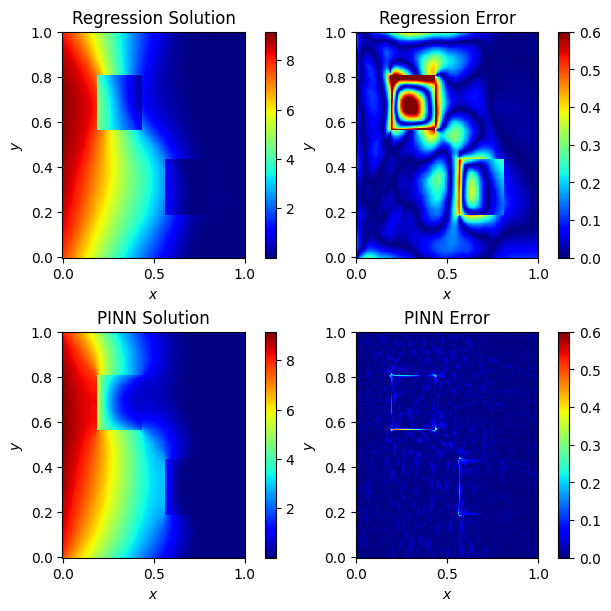

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = E_ref.min()
vmax = E_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, E_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (E_ref - E_reg).abs(), vmin=0, vmax=0.6, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, E_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (E_ref - E_pinn).abs(), vmin=0, vmax=0.6, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])

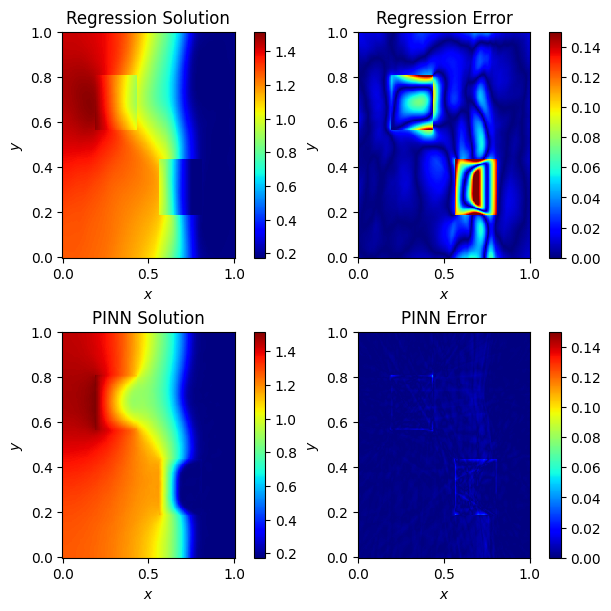

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = T_ref.min()
vmax = T_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, T_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (T_ref - T_reg).abs(), vmin=0, vmax=0.15, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, T_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (T_ref - T_pinn).abs(), vmin=0, vmax=0.15, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])